In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import gzip
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

from common import * 
import preprocess
import model_io

In [6]:
DATA_DIR = 'data/clean_1'

log = preprocess.load_driving_log(os.path.join(DATA_DIR, DRIVING_LOG_CSV))
log = preprocess.smooth_control_inputs(log, 1)
print(log.head())

                                        center_image  \
0  data/clean_1/IMG/center_2016_12_04_21_13_56_21...   
1  data/clean_1/IMG/center_2016_12_04_21_13_56_33...   
2  data/clean_1/IMG/center_2016_12_04_21_13_56_45...   
3  data/clean_1/IMG/center_2016_12_04_21_13_56_57...   
4  data/clean_1/IMG/center_2016_12_04_21_13_56_72...   

                                          left_image  \
0  data/clean_1/IMG/left_2016_12_04_21_13_56_217.jpg   
1  data/clean_1/IMG/left_2016_12_04_21_13_56_334.jpg   
2  data/clean_1/IMG/left_2016_12_04_21_13_56_454.jpg   
3  data/clean_1/IMG/left_2016_12_04_21_13_56_577.jpg   
4  data/clean_1/IMG/left_2016_12_04_21_13_56_725.jpg   

                                         right_image  steering_angle  \
0  data/clean_1/IMG/right_2016_12_04_21_13_56_217...             0.0   
1  data/clean_1/IMG/right_2016_12_04_21_13_56_334...             0.0   
2  data/clean_1/IMG/right_2016_12_04_21_13_56_454...             0.0   
3  data/clean_1/IMG/right_2016_12_04_2

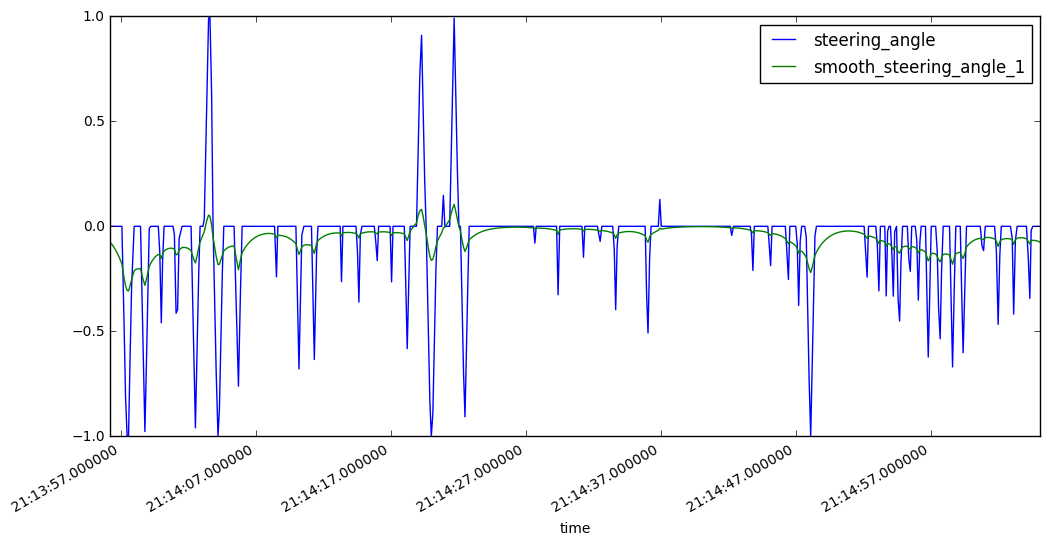

In [7]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

In [8]:
log.to_pickle(os.path.join(DATA_DIR, DRIVING_LOG_PICKLE))

In [9]:
import math
import cv2

def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -20 degrees to 20 degrees.
    """
    return math.radians(steering_angle * 20.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filename,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # at least for Mac
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
        if i % 50 == 0:
            print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()
make_steering_movie('test.mp4', log[0:50], 'smooth_steering_angle_1')

frame 0


# Base Model

The full inception model is too slow for my laptop, so I am just using the first few layers.

Loading the whole inception model is very slow, so we also cut out only the weights we need and save them for loading later.

In [6]:
import inception
import model_io

model_io.save_model(
    BASE_MODEL_JSON_FILE,
    BASE_MODEL_WEIGHTS_FILE,
    inception.make_cut_model())

Using TensorFlow backend.


In [10]:
model_io.load_base_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 79, 159, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 79, 159, 32)   64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 77, 157, 32)   9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

# Bottleneck

Training is hopelessly slow if we don't botteneck the features.

In [10]:
import bottleneck_features

In [11]:
bottleneck_features.run(log, DATA_DIR)

index 0
index 50
index 100
index 150
index 200
index 250
index 300
index 350
index 400
index 450
index 500
index 550
index 600
index 650
index 700
index 750
index 800
index 850
index 900
index 950
index 1000
index 1050
index 1100
index 1150
index 1200
index 1250
index 1300
index 1350
index 1400
index 1450
index 1500
index 1550
index 1600
index 1650
index 1700
index 1750
index 1800
index 1850
index 1900
index 1950
index 2000
index 2050
index 2100
index 2150
index 2200
index 2250
index 2300
index 2350
index 2400
index 2450
index 2500
index 2550
index 2600
index 2650
index 2700
index 2750
index 2800
index 2850
index 2900
index 2950
index 3000


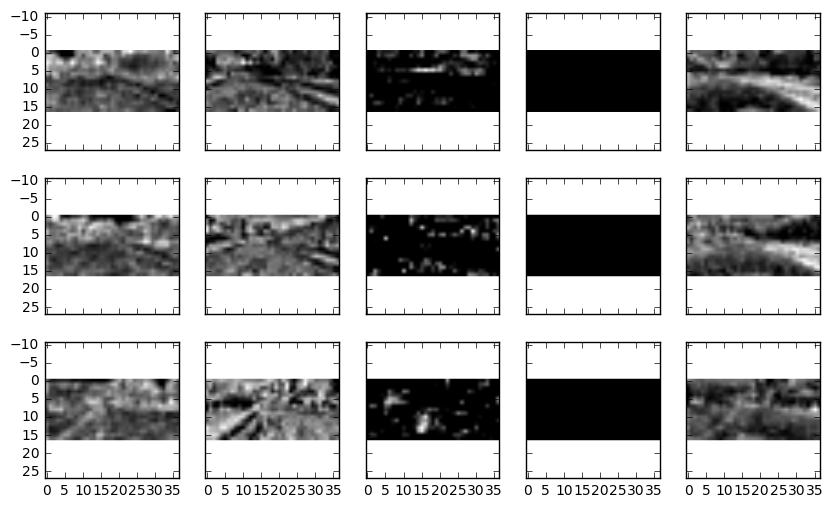

In [13]:
def plot_bottleneck_output(num_images, num_channels, image_stride=50):
    fig, axes = plt.subplots(num_images, num_channels,
                             figsize=(2*num_channels, 2*num_images),
                             sharex=True, sharey=True)
    for i in range(num_images):
        for j in range(num_channels):
            index = i * image_stride
            image = np.load(get_bottleneck_pathname(DATA_DIR, index))['center_image']
            axes[i][j].imshow(image[:,:,j], cmap='gray')
plot_bottleneck_output(3,5)

In [ ]:
# from keras.applications.inception_v3 import preprocess_input
# from scipy.misc import imread
# import model
# from datetime import datetime
# base_model = model.make_base_model()
# base_model.summary()
# def test_convert():
#     """
#     See how long it takes to run a prediction.
#     """
#     image = imread('data/clean_1/IMG/center_2016_12_04_21_19_10_094.jpg')
#     plt.imshow(image)

#     print(datetime.now(), 'preprocess')
#     X = preprocess_input(image.astype('float32'))
#     print(datetime.now(), 'predict')
#     base_X = base_model.predict(np.array([X]))
#     print(datetime.now(), base_X.shape)
#     base_X = np.reshape(base_X, (17, 37, 256))
#     plt.imshow(base_X[:,:,1], cmap='gray')
# test_convert()

# Model

In [22]:
import model

In [23]:
result_model = model.build(
    input_shape=np.load(get_bottleneck_pathname(DATA_DIR, 0))['center_image'].shape
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 17, 37, 64)    16448       convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 40256)         0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             40257       flatten_3[0][0]                  
Total params: 56705
____________________________________________________________________________________________________


In [24]:
model.train(result_model, DATA_DIR, log)

Epoch 1/1
2418/2418 [==============================] - 64s - loss: 0.2259 - val_loss: 0.0192


In [25]:
model_io.save_model('model.json', 'model.h5', result_model)

In [26]:
base_model = model_io.load_base_model()

2016-12-07 23:30:18.866664 preprocess
2016-12-07 23:30:18.867468 base predict
2016-12-07 23:30:19.066349 predict
2016-12-07 23:30:19.631505 result 0.07920446991920471


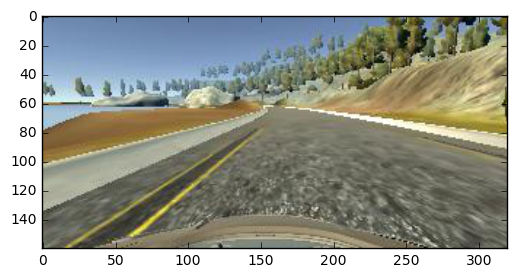

In [47]:
result_model = model_io.load_model('model.json', 'model.h5')

In [36]:
log['predicted_steering_angle'] = result_model.predict_generator(
    model.generate_data(DATA_DIR, log, np.arange(len(log))),
    val_samples=len(log)
).flatten()

In [37]:
make_steering_movie('test.mp4', log[0:500], 'smooth_steering_angle_1', 'predicted_steering_angle')

frame 0
frame 50
frame 100
frame 150
frame 200
frame 250
frame 300
frame 350
frame 400
frame 450


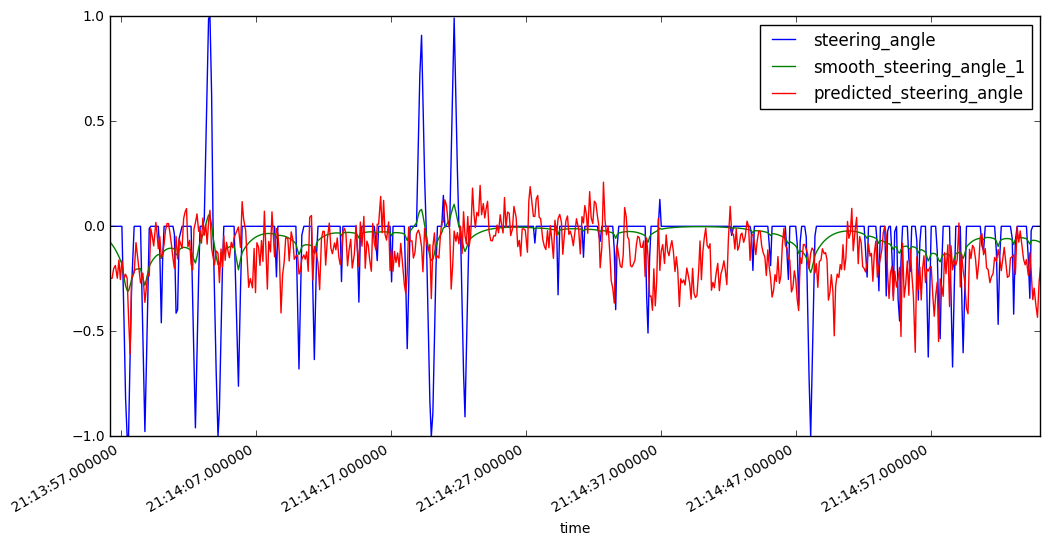

In [41]:
def plot_predicted_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'predicted_steering_angle']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_predicted_steering_angle()

NameError: name 'bottleneck_center_image' is not defined